# DATA INVESTIGATION
    ## Analysis on BeerAdvocate
        ### Handling missing values
        ### Checking for data inconsistencies
        ### Initial data analysis
            #### Initial analysis on BeerTypes
            #### Initial analysis on Grading columns
            #### Initial analysis on grading over time
                ##### Days of the week analysis
                ##### Monthly analysis
            

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

### Analysis on BeerAdvocate

Load data from pickles. To obtain pickles run the notebook _data_import.ipynb_

In [2]:
# load Beer Advocate data from pickles
ratings = pd.read_pickle('./datasets/BeerAdvocate/ratings.pkl')
reviews = pd.read_pickle('./datasets/BeerAdvocate/reviews.pkl')

In [3]:
print('Ratings - Rows: {}, columns {}'.format(ratings.shape[0], ratings.shape[1]))
print('Reviews - Rows: {}, columns {}'.format(reviews.shape[0], reviews.shape[1]))
reviews.head(2)

Ratings - Rows : 8393033, columns 17
Reviews - Rows : 2589587, columns 17


,Beer Name,Beer Id,Brewery Name,Brewery Id,Style,Abv,Date,Username,User Id,Appearance,Aroma,Palate,Taste,Overall,Rating,Text,Review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 12:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",None
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 12:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,None


### Handling missing values

We investigate missing values for ratings and reviews. The datapoint with uknown beer that is rated is invalid.

In [4]:
ratings = ratings[ratings['Beer Id'].notna()]
reviews = reviews[reviews['Beer Id'].notna()]

We always know who rated the beer and when the beer is rated : 

In [5]:
assert len(ratings) == len(ratings[ratings['User Id'].notna()])
assert len(ratings) == len(ratings[ratings['Date'].notna()])

assert len(reviews) == len(reviews[reviews['User Id'].notna()])
assert len(reviews) == len(reviews[reviews['Date'].notna()])

##### How many ratings/reviews do not have grades for certain aspects, total rating or review?

In [6]:
# reviws
d = {'Percentage of present entries (%)': [100*len(reviews[reviews['Appearance'].notna()])/len(reviews),
    100*len(reviews[reviews['Aroma'].notna()])/len(reviews), 100*len(reviews[reviews['Palate'].notna()])/len(reviews),
    100*len(reviews[reviews['Taste'].notna()])/len(reviews), 100*len(reviews[reviews['Overall'].notna()])/len(reviews),
    100*len(reviews[reviews['Rating'].notna()])/len(reviews), 100*len(reviews[reviews['Text'].notna()])/len(reviews),], 
     'Variables': ['Appearance','Aroma','Palate','Taste','Overall','Rating','Text']}

# dataframe to display data
power_stats_dataframe = pd.DataFrame.from_dict(data=d).set_index('Variables')
power_stats_dataframe.style.set_caption('Reviews :')

,Percentage of present entries (%)
Variables,
Appearance,98.763934
Aroma,98.763934
Palate,98.763934
Taste,98.763934
Overall,98.763934
Rating,100.000000
Text,100.000000


In [7]:
# ratings
d = {'Percentage of present entries (%)': [100*len(ratings[ratings['Appearance'].notna()])/len(ratings),
    100*len(ratings[ratings['Aroma'].notna()])/len(ratings), 100*len(ratings[ratings['Palate'].notna()])/len(ratings),
    100*len(ratings[ratings['Taste'].notna()])/len(ratings), 100*len(ratings[ratings['Overall'].notna()])/len(ratings),
    100*len(ratings[ratings['Rating'].notna()])/len(ratings), 100*len(ratings[ratings['Text'].notna()])/len(ratings),], 
     'Variables': ['Appearance','Aroma','Palate','Taste','Overall','Rating','Text']}

# dataframe to display data
power_stats_dataframe = pd.DataFrame.from_dict(data=d).set_index('Variables')
power_stats_dataframe.style.set_caption('Ratings :')

,Percentage of present entries (%)
Variables,
Appearance,56.828986
Aroma,56.828986
Palate,56.828986
Taste,56.828986
Overall,56.828986
Rating,100.000000
Text,100.000000


The presence of non-values for Appearance, Aroma, Palate, Taste and Overall are the same. Do they correspond to the same datapoints?

In [8]:
print('Ratings - Correspond to the same datapoints: ')
(ratings[ratings['Appearance'].isna()].equals(ratings[ratings['Aroma'].isna()])) and \
(ratings[ratings['Appearance'].isna()].equals(ratings[ratings['Taste'].isna()])) and \
(ratings[ratings['Appearance'].isna()].equals(ratings[ratings['Overall'].isna()]))

Ratings - Correspond to the same datapoints: 


True

In [9]:
print('Reviews - Correspond to the same datapoints: ')
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Aroma'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Taste'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Overall'].isna()]))

Reviews - Correspond to the same datapoints: 


True

Therefore, the reviews that have an aspect missing, have all the aspects missing.
Since there are 1.24% of missing aspects in the Reviews and  43.18% of missing aspects in the Ratings, we won't discard them, but we will be aware of them.

### Checking for data inconsistencies

Check for duplicates in ratings and reviews.

In [44]:
print('Duplicated rows in ratings : {}'.format(sum(ratings.duplicated())))
print('Duplicated rows in reviews : {}'.format(sum(reviews.duplicated())))

Duplicated rows in ratings : 0
Duplicated rows in reviews : 0


Are there reviews in the intersection of ratings and reviws dataframes?

In [65]:
# Since there are no duplicates in both dataframes, we compare the len of the intersection and the length of 
# the smaller dataframe. We obtain the intersection by merging between ratings and reviews
# We exclude only Review column for merge since it's None in reviews
assert len(ratings.merge(reviews, how='inner', on=ratings.columns.to_list()[:16])) == len(reviews)

Since the lengths are the same, we conclude the reviews dataframe is strict subset of ratings dataframe and we continue the analysis only for ratings dataframe.

Are there multiple ratings from the same user for the same beer? 

In [10]:
multiple_ratings = ratings.groupby(['Beer Id','User Id']).agg('count') > 1
if sum(multiple_ratings.any()) == 0:
    print('No repetitions for the same beer and user')

No repetitions for the same beer and user


Is there an invalid rating (not in range 1-5)?

In [11]:
assert len(ratings[(ratings['Appearance'] < 1) | (ratings['Appearance'] > 5)]) == 0
assert len(ratings[(ratings['Aroma'] < 1) | (ratings['Aroma'] > 5)]) == 0
assert len(ratings[(ratings['Taste'] < 1) | (ratings['Taste'] > 5)]) == 0
assert len(ratings[(ratings['Overall'] < 1) | (ratings['Overall'] > 5)]) == 0
assert len(ratings[(ratings['Rating'] < 1) | (ratings['Rating'] > 5)]) == 0

Is there invalid ABVs?

In [27]:
assert len(ratings[ratings['Abv'] < 0]) == 0
assert len(ratings[ratings['Abv'] > 70]) == 0

There are no inconsistencies in BeerAdvocate datasets.

## Initial data analysis

#### Initial analysis on Style
Each beer has its Style. Let's group the beers based on style and have a glane at the data.

In [71]:
# group by styles and take means (meaningful for given grades)
ratings_by_style = ratings.groupby('Style').mean().sort_values('Overall')
ratings_by_style

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating
Style,,,,,,,,,
Light Lager,18038.509265,1122.64075,4.128620,2.483369,2.243034,2.395945,2.335784,2.551422,2.220336
Low Alcohol Beer,34456.858252,2176.660907,0.591579,2.924174,2.541306,2.551239,2.498918,2.579170,2.454067
American Malt Liquor,36197.75599,1835.28412,7.254881,2.801211,2.485947,2.647849,2.557949,2.638730,2.429489
American Adjunct Lager,11525.757261,1730.614414,4.856284,2.834799,2.557520,2.768130,2.722332,2.881181,2.622378
Euro Strong Lager,34759.287774,4025.544608,8.270904,3.209042,2.900377,2.975996,2.864639,2.896448,2.905391
...,...,...,...,...,...,...,...,...,...
Russian Imperial Stout,52437.259287,7158.319342,10.574000,4.238174,4.136580,4.143917,4.186838,4.132943,4.189310
American Double / Imperial IPA,84052.38902,11564.621192,9.092228,4.155796,4.158329,4.121966,4.166498,4.135216,4.163593
Quadrupel (Quad),44154.849822,4787.733191,10.706392,4.136286,4.147425,4.132461,4.205725,4.137940,4.199219


There are 104 beer styles. 
It seems that better rated beers have higher ABV. We can execute further analysis to conclude it.

In [163]:
# top half styles (by Overall grade)
ratings_style_head = ratings_by_style.head(52)
# bottom half styles (by Overall grade)
ratings_style_tail = ratings_by_style.tail(52)
# compare alcholol levels for top and bottom halves
print('Top rated mean of ABV : {:.4f} %'.format(reviews_style_head['Abv'].mean()))
print('Bottom rated mean of ABV : {:.4f} %'.format(reviews_style_tail['Abv'].mean()))

Top rated mean of ABV : 5.6939 %
Bottom rated mean of ABV : 7.3981 %


It seems like the beers with higher ABV are more liked. We execute the test to compare the findings. Populations are bottom ABV and top ABV halves and we compare are the means of the overall ratings different for these populations.

In [72]:
# is there a difference in ratings between beers with lower and high alcohol levels
ratings_by_style = ratings.groupby('Style').mean().sort_values('Abv')
# less alcohol
ratings_style_head = ratings_by_style.head(52)
# more alcohol
ratings_style_tail = ratings_by_style.tail(52)
t_indep = scipy.stats.ttest_ind(ratings_style_head['Overall'], ratings_style_tail['Overall'], equal_var=False)
t_indep

Ttest_indResult(statistic=-3.545907935145777, pvalue=0.000603427706744739)

We reject the null hypothesis the means are the same. Since the test statistic is negative and the first group is the group with lower ABV, we conclude that beers with higher ABV obtain better ratings. 

#### Initial analysis on Grading columns

People rated different aspects of beers, namely appearance, aroma, palate, taste and overall. We visually inspect what are the distributions of grades. We show only granularity by full grades, since people more rarely gave grades which end on 0.25 or 0.75.

In [74]:
grading_columns = ratings.columns[9:15]
print(grading_columns)

Index(['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall', 'Rating'], dtype='object')


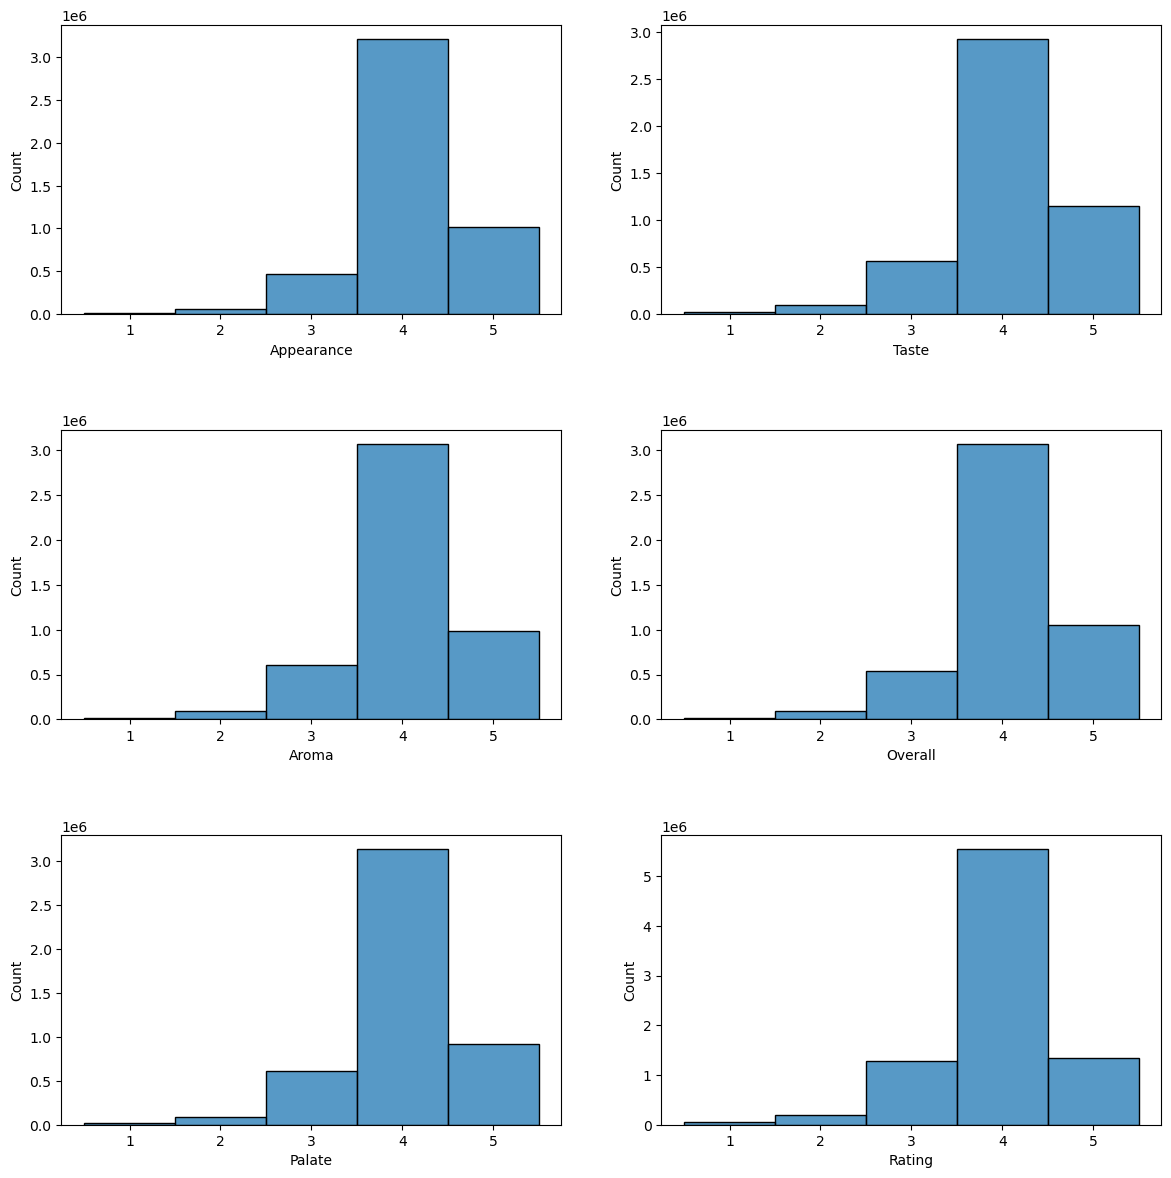

In [75]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.histplot(ax=axes[grading_index%3, grading_index//3], data = ratings[grading_columns[grading_index]], discrete=True)
    

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

#### Initial analysis on grading over time

##### Days of the week analysis

In [77]:
ratings['weekday'] = ratings['Date'].apply(lambda x: x.weekday())

<AxesSubplot:xlabel='weekday', ylabel='Count'>

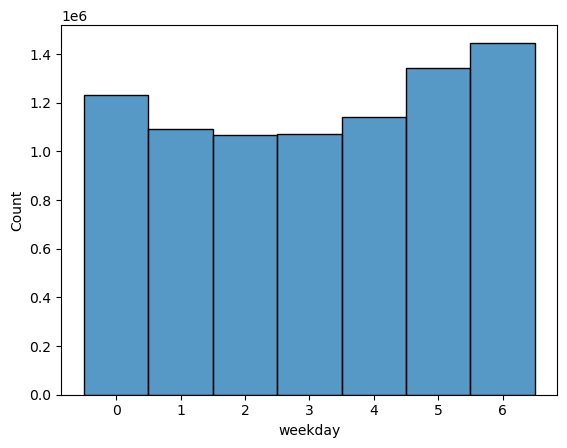

In [78]:
sns.histplot(data = ratings['weekday'], discrete=True)

<AxesSubplot:xlabel='weekday'>

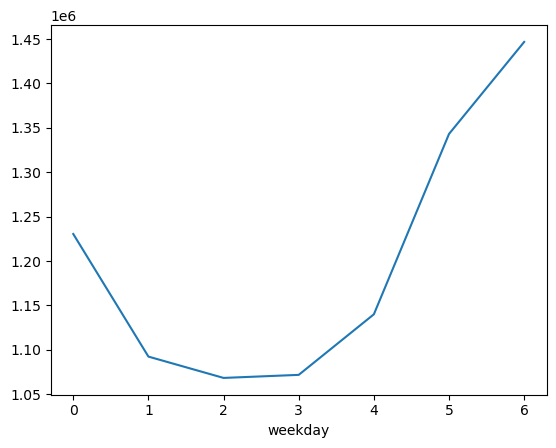

In [79]:
sns.lineplot(data = ratings.groupby('weekday').size())

In [81]:
print ('Sunday : {}'.format((ratings['weekday']==6).sum()))
print ('Saturday : {}'.format((ratings['weekday']==5).sum()))
print ('Tuesday : {}'.format((ratings['weekday']==2).sum()))

Sunday : 1446787
Saturday : 1343168
Tuesday : 1068373


## Todo : comment differences between Tuesday and Weekend

In [89]:
ratings_by_weekday = ratings.groupby('weekday').mean()
ratings_by_weekday

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating,month
weekday,,,,,,,,,,
0,67228.105912,9320.40559,7.383152,3.937552,3.874968,3.869142,3.905575,3.902595,3.891265,6.558802
1,63460.12543,8731.869188,7.329286,3.931138,3.865280,3.859874,3.896549,3.896102,3.881024,6.637483
2,63338.322335,8675.241959,7.311374,3.930138,3.862899,3.857302,3.895105,3.895302,3.876695,6.572659
3,64220.774939,8771.7015,7.312582,3.935856,3.866054,3.862548,3.899429,3.898606,3.880521,6.544876
4,66494.580997,9015.858125,7.302453,3.935914,3.865647,3.861857,3.899688,3.897734,3.880269,6.529164
5,70126.041039,9523.566921,7.317608,3.944233,3.874182,3.872695,3.910210,3.904607,3.882639,6.448879
6,70313.257846,9593.832208,7.346891,3.941897,3.874633,3.872914,3.911457,3.905648,3.881398,6.396725


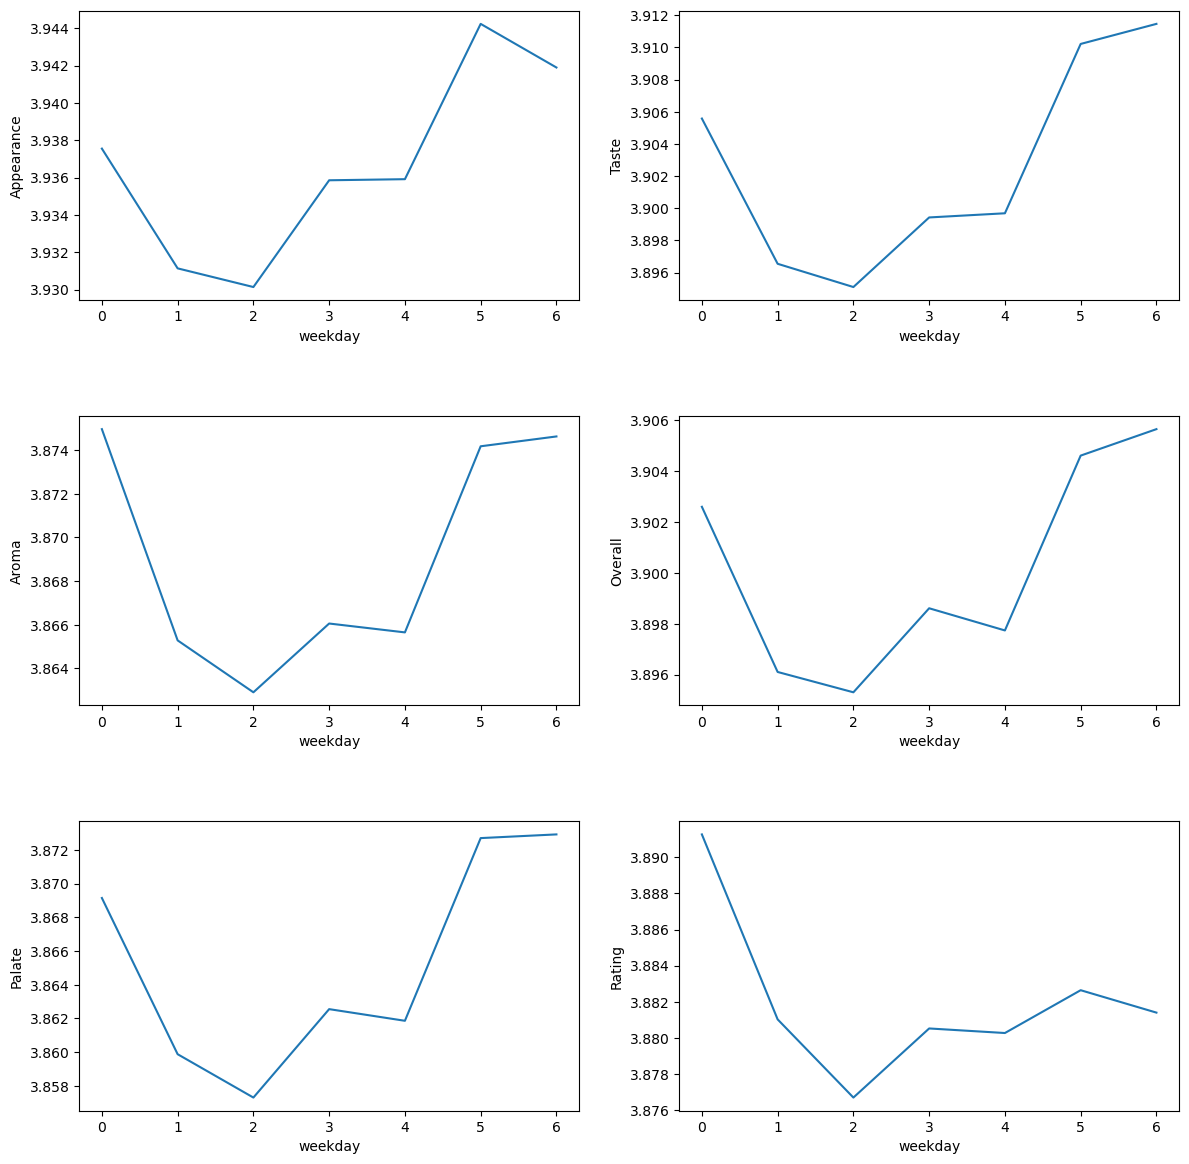

In [90]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = ratings_by_weekday[grading_columns[grading_index]])
    

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

##### Monthly analysis

In [84]:
ratings['month'] = ratings['Date'].apply(lambda x: x.month)

<AxesSubplot:xlabel='month', ylabel='Count'>

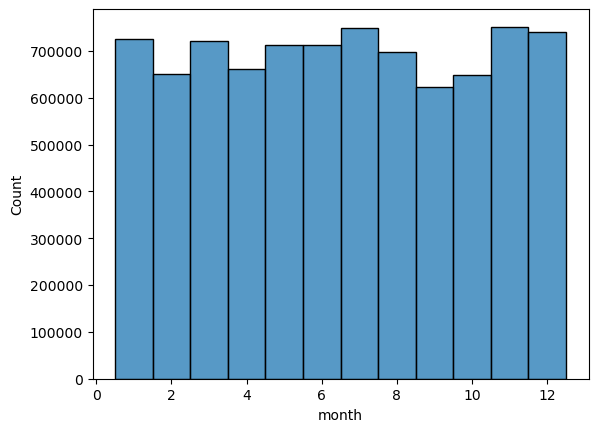

In [85]:
sns.histplot(data = ratings['month'], discrete=True)

Have a glance at the dataframe obtained by grouping by month to see are differences between grades or alcohol levels.

In [86]:
ratings_by_month = ratings.groupby('month').mean()
ratings_by_month

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating,weekday
month,,,,,,,,,,
1,62904.297048,8464.488517,7.531958,3.956382,3.888755,3.879938,3.921893,3.916933,3.888557,3.220875
2,67222.702499,8999.991657,7.497626,3.962165,3.895324,3.888202,3.928088,3.923332,3.897956,3.180830
3,69198.482189,9518.185956,7.479663,3.962169,3.893380,3.888002,3.927785,3.922109,3.906566,3.241043
4,70886.974659,9603.324699,7.398861,3.952866,3.886800,3.884384,3.921799,3.916477,3.900407,3.175312
5,72469.165091,9807.119266,7.287710,3.934043,3.868856,3.869998,3.905211,3.902568,3.880284,3.139498
6,73348.835322,10042.588336,7.191877,3.928846,3.862535,3.865047,3.898661,3.896155,3.873973,3.124841
7,71360.208162,9705.385187,7.117093,3.920364,3.855839,3.858467,3.889234,3.887745,3.856780,3.082666
8,63347.194768,8893.071911,7.098323,3.907526,3.836838,3.836635,3.871450,3.873341,3.844434,3.168829
9,63327.40188,8850.179338,7.116822,3.909370,3.838080,3.836963,3.872294,3.873957,3.849111,3.101547


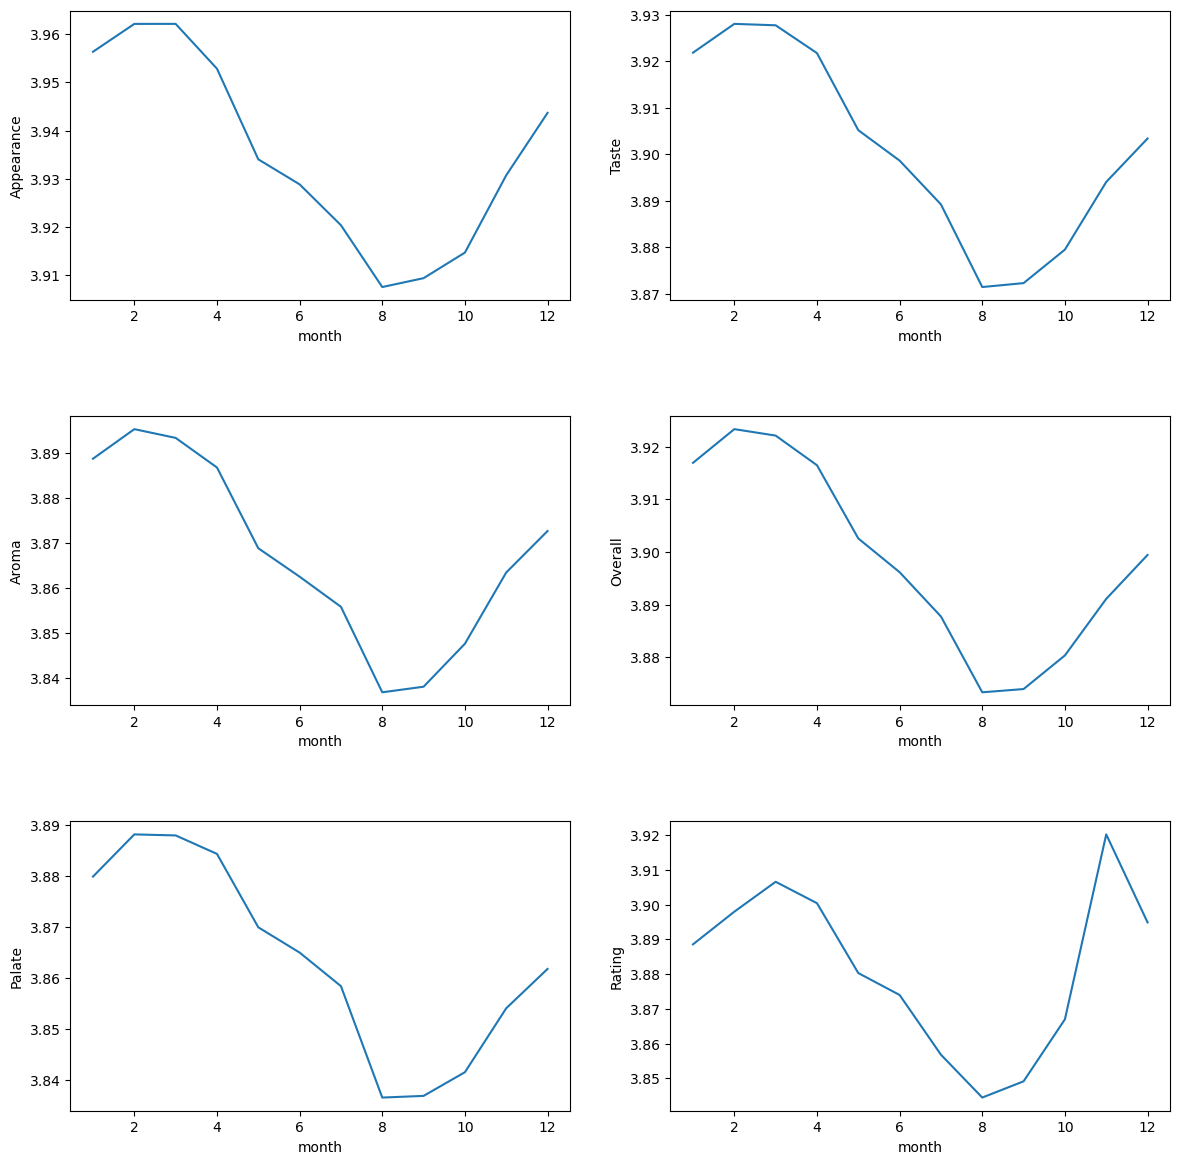

In [88]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = ratings_by_month[grading_columns[grading_index]])
    

# set figure size
fig.set_size_inches(11, 11)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

# TODO :
We execute a test to compare are the means for the grades for different aspects different for different months.

In [2]:
beers = pd.read_csv('./datasets/BeerAdvocate/beers.csv')

In [3]:
beers.shape

(280823, 15)

In [4]:
beers.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [7]:
len(beers[beers['nbr_ratings'] > 11730])

10

In [42]:
len(beers[beers['nbr_reviews'] > 730])

482

In [137]:
len(beers[(beers['nbr_ratings'] > 730) & (beers['abv']<3.5)])

7

In [146]:
beers[(beers['nbr_ratings'] > 730) & (beers['abv']<4.5)].sort_values('nbr_ratings')

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
137042,79669,Shock Top Lemon Shandy,29,Anheuser-Busch,Fruit / Vegetable Beer,740,107,2.79,66.0,NaN,4.20,2.828919,NaN,0,NaN
12796,6508,Victoria,75,Grupo Modelo S.A. de C.V.,Vienna Lager,741,179,2.97,70.0,NaN,4.00,2.937031,NaN,0,NaN
261501,48873,Wyld Extra Pale Ale,1416,Uinta Brewing Company,American Pale Ale (APA),749,191,3.52,80.0,NaN,4.00,3.524259,-0.634726,198,3.526919
67686,35735,Miller Chill,105,Miller Brewing Co.,Light Lager,758,341,2.05,52.0,42.0,4.10,1.944802,NaN,0,NaN
198097,71866,Clara Grisette,22511,Hill Farmstead Brewery,Saison / Farmhouse Ale,766,130,4.11,91.0,NaN,4.00,4.134804,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67695,332,Miller Lite,105,Miller Brewing Co.,Light Lager,4524,1199,2.28,55.0,59.0,4.17,2.180979,NaN,0,NaN
251298,17141,312 Urban Wheat,1146,Goose Island Beer Co.,American Pale Wheat Ale,4544,925,3.42,78.0,79.0,4.20,3.389241,NaN,0,NaN
133621,837,Coors Light,306,Coors Brewing Company,Light Lager,5113,1292,2.05,51.0,45.0,4.20,2.022478,NaN,0,NaN
136907,1320,Bud Light,29,Anheuser-Busch,Light Lager,5878,1443,1.93,48.0,43.0,4.20,1.859842,NaN,0,NaN


In [156]:
low_abv_high_number_of_ratings = ratings[ratings['Beer Name'] == ' Guinness Draught']

<AxesSubplot:xlabel='Date', ylabel='Count'>

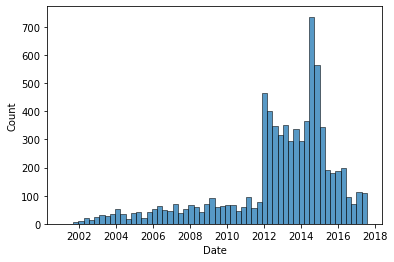

In [157]:
sns.histplot(data=low_abv_high_number_of_ratings, x='Date')

In [153]:
beers[(beers['nbr_ratings'] > 12030) & (beers['abv']>8)].sort_values('nbr_ratings')

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
251429,10672,Bourbon County Brand Stout,1146,Goose Island Beer Co.,American Double / Imperial Stout,12193,2952,4.50,100.0,95.0,13.8,4.599114,NaN,0,NaN
77815,412,Old Rasputin Russian Imperial Stout,112,North Coast Brewing Co.,Russian Imperial Stout,12194,3722,4.28,95.0,97.0,9.0,4.301165,NaN,0,NaN
226360,19960,Founders KBS (Kentucky Breakfast Stout),1199,Founders Brewing Company,American Double / Imperial Stout,12599,3221,4.56,100.0,NaN,11.8,4.607697,NaN,0,NaN
225867,17112,Hopslam Ale,287,"Bell's Brewery, Inc.",American Double / Imperial IPA,13026,3527,4.43,98.0,94.0,10.0,4.462041,NaN,0,NaN
180458,2093,90 Minute IPA,64,Dogfish Head Brewings & Eats,American Double / Imperial IPA,15548,3899,4.24,94.0,96.0,9.0,4.273975,NaN,0,NaN
226278,11757,Founders Breakfast Stout,1199,Founders Brewing Company,American Double / Imperial Stout,16509,3811,4.47,99.0,100.0,8.3,4.513760,NaN,0,NaN


In [159]:
high_abv_high_number_of_ratings = ratings[ratings['Beer Name'] == ' 90 Minute IPA']

<AxesSubplot:xlabel='Date', ylabel='Count'>

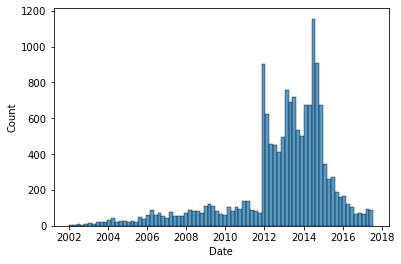

In [160]:
sns.histplot(data=high_abv_high_number_of_ratings, x='Date')

In [62]:
ratings.groupby('Date').size().sort_values().tail(30)

Date
2014-08-17 12:00:00     7254
2014-11-15 12:00:00     7255
2014-11-23 12:00:00     7261
2014-12-14 12:00:00     7274
2014-09-13 12:00:00     7288
2014-11-30 12:00:00     7302
2014-06-29 12:00:00     7322
2014-08-09 12:00:00     7328
2014-07-12 12:00:00     7331
2014-09-28 12:00:00     7420
2014-07-26 12:00:00     7449
2014-08-16 12:00:00     7503
2014-11-16 12:00:00     7521
2014-10-19 12:00:00     7586
2014-12-07 12:00:00     7606
2014-07-13 12:00:00     7609
2014-08-10 12:00:00     7649
2014-07-19 12:00:00     7698
2014-07-27 12:00:00     7732
2014-10-28 12:00:00     8018
2014-11-09 12:00:00     8085
2014-09-01 12:00:00     8153
2014-08-03 12:00:00     8282
2011-11-17 12:00:00     8292
2014-10-26 12:00:00     8658
2011-11-18 12:00:00     8770
2014-07-20 12:00:00     9088
2011-11-16 12:00:00     9593
2011-11-14 12:00:00    17131
2011-11-15 12:00:00    17696
dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Count'>

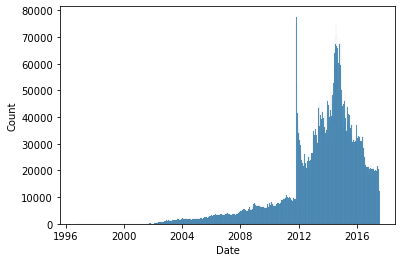

In [161]:
sns.histplot(data=ratings['Date'])

<AxesSubplot:xlabel='Date', ylabel='Count'>

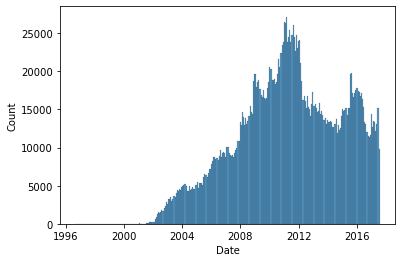

In [162]:
sns.histplot(data=reviews['Date'])

In [30]:
# 2.1 (provided code)

def count_words_simple(x):
    if x == None:
        return 0
    return len(x.split(" "))
str_test = "How many words are here?"
print(str_test, count_words_simple(str_test))

How many words are here? 5


In [31]:
reviews['num_words'] = reviews['Text'].apply(lambda x: count_words_simple(x))

In [32]:
reviews['num_words'].nunique()

935

In [36]:
num_words_grouped = reviews.groupby('num_words').mean()
num_words_grouped

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating
num_words,,,,,,,,,
0,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40640.285714,8152.714286,7.385714,3.964286,4.000,3.785714,3.821429,3.964286,3.898571
3,171091.5,17460.5,7.325000,3.625000,3.625,3.500000,3.125000,3.375000,3.365000
5,110491.5,14654.5,7.250000,4.000000,4.125,3.875000,4.000000,4.000000,4.020000
6,66455.0,13617.0,6.000000,4.000000,3.500,3.500000,3.500000,3.625000,3.555000
...,...,...,...,...,...,...,...,...,...
958,91918.0,25370.0,8.000000,4.250000,4.000,4.000000,4.000000,4.000000,4.020000
959,46188.0,199.0,10.000000,4.000000,4.000,3.500000,3.500000,4.000000,3.750000
968,22405.0,794.5,7.250000,4.250000,3.500,4.000000,4.000000,4.000000,3.895000


In [45]:
reviews.groupby('num_words').size()

num_words
0      1
2      7
3      2
5      2
6      2
      ..
958    1
959    1
968    2
977    1
986    1
Length: 935, dtype: int64

<AxesSubplot:xlabel='num_words'>

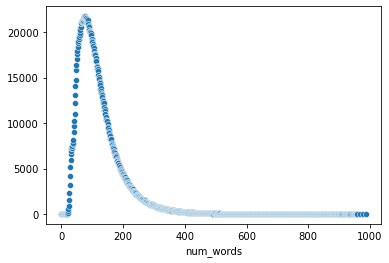

In [47]:
sns.scatterplot(data=reviews.groupby('num_words').size())

In [63]:
num_words_grouped[(num_words_grouped.index < 80) & (num_words_grouped.index > 0)]

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating
num_words,,,,,,,,,
2,40640.285714,8152.714286,7.385714,3.964286,4.000000,3.785714,3.821429,3.964286,3.898571
3,171091.5,17460.5,7.325000,3.625000,3.625000,3.500000,3.125000,3.375000,3.365000
5,110491.5,14654.5,7.250000,4.000000,4.125000,3.875000,4.000000,4.000000,4.020000
6,66455.0,13617.0,6.000000,4.000000,3.500000,3.500000,3.500000,3.625000,3.555000
7,71555.5,17089.5,7.100000,3.500000,3.750000,3.750000,3.875000,3.750000,3.785000
...,...,...,...,...,...,...,...,...,...
75,47256.899216,6227.424723,6.897963,3.839421,3.732601,3.754248,3.787505,3.812722,3.780548
76,46701.443519,6166.35292,6.917562,3.848513,3.743298,3.764334,3.797738,3.816819,3.789134
77,46705.541871,6167.933441,6.907032,3.847124,3.745652,3.761099,3.795743,3.816429,3.789296


In [67]:
num_words_grouped[(num_words_grouped.index < 50) & (num_words_grouped.index > 0)].mean()

Beer Id       88088.828611
Brewery Id    12052.905276
Abv               6.978496
Appearance        3.941726
Aroma             3.832328
Palate            3.820621
Taste             3.848250
Overall           3.851267
Rating            3.849524
dtype: float64

In [66]:
num_words_grouped[num_words_grouped.index > 200].mean()

Beer Id       58947.998238
Brewery Id     7359.185943
Abv               8.337028
Appearance        3.950849
Aroma             3.931187
Palate            3.871252
Taste             3.932135
Overall           3.913814
Rating            3.921944
dtype: float64